In [1]:
import numpy as np
import cupy as cp

import poppy
from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

from scoobpsf import scoobm, agpm
reload(scoobm)

import lina
xp = lina.math_module.xp
from lina.imshows import imshow1, imshow2, imshow3

# import misc_funs as misc

poppy_log.disabled = True

pupil_diam = 6.75*u.mm
wavelength_c = 632.8e-9*u.m

dm_flat = fits.getdata(scoobm.module_path/'scoob_dm_flat.fits')

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, rotation=20)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3.6*u.mm/2, gray_pixel=False)




Could not import scoobpy. Testbed interface unavailable.


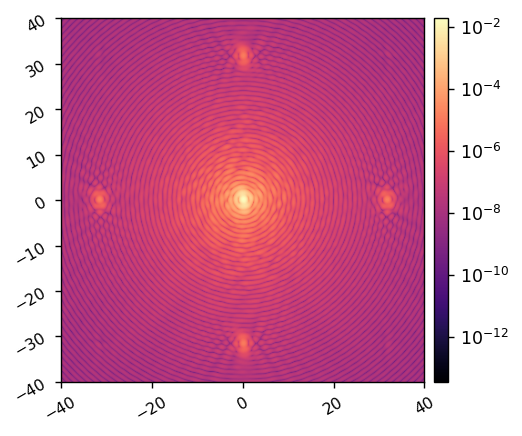

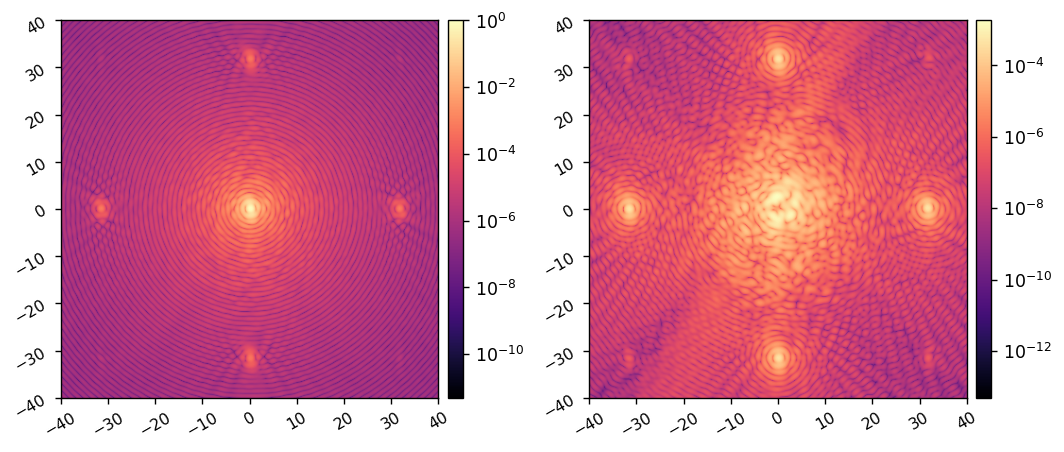

In [2]:
reload(scoobm)
model = scoobm.SCOOBM(dm_ref=dm_flat)
model.npix = 512
model.oversample = 4
model.det_rotation = 0

ref_im = model.snap(True)

model.imnorm = ref_im.max()
normalized_im = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

occ_im = model.snap()
imshow2(normalized_im, occ_im, lognorm1=True, lognorm2=True, pxscl=model.psf_pixelscale_lamD)

Nact = model.Nact
npsf = model.npsf
psf_pixelscale_lamD = model.psf_pixelscale_lamD

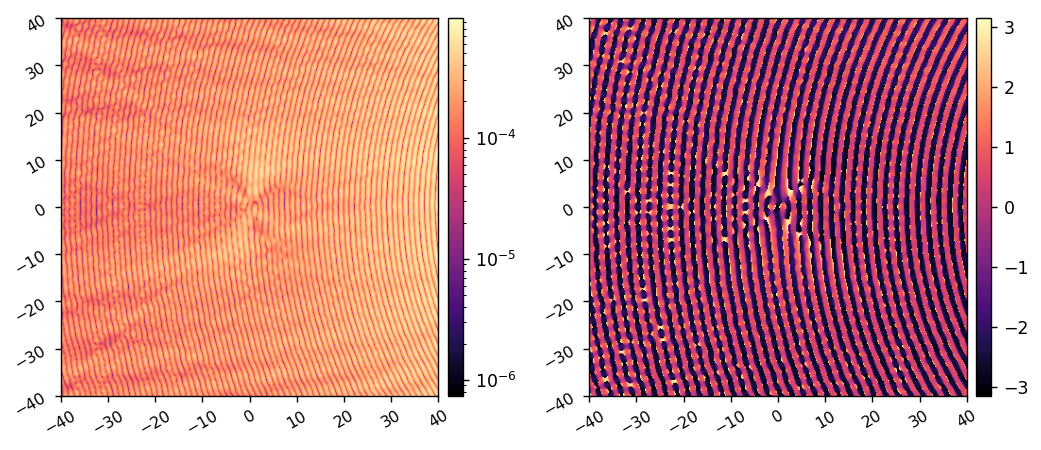

In [3]:
model.source_offset = (100,0)
im = model.calc_psf(True)

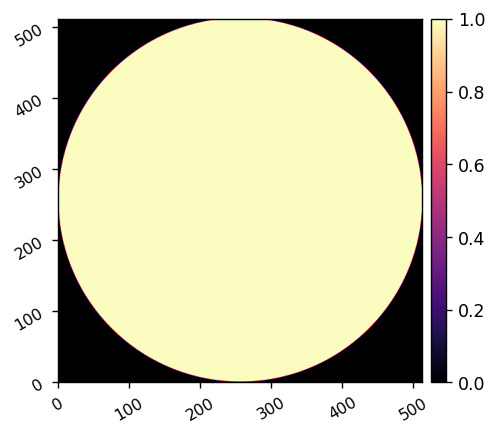

16


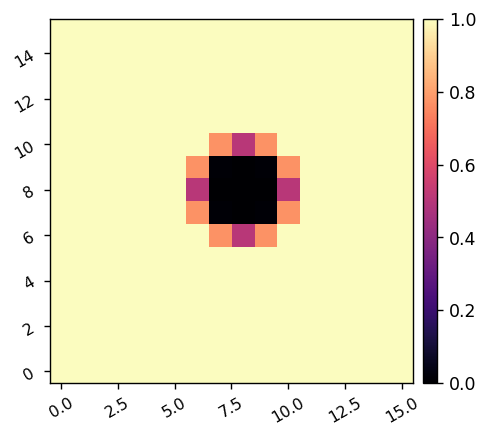

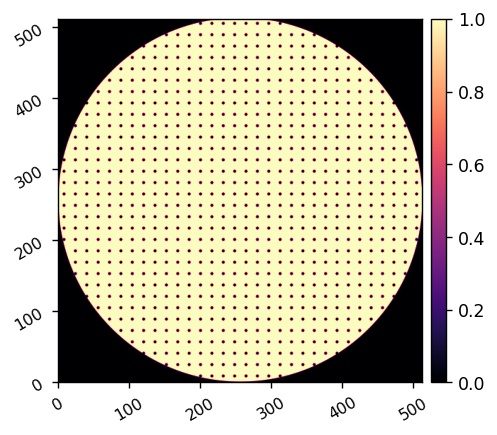

In [25]:
reload(lina.utils)
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=model.npix, oversample=1)
ap = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(wf)
imshow1(ap)

grating_period = pupil_diam.to(u.m)/34
grating_period_pix = grating_period.to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
grating_period_pix = round(grating_period_pix/2)*2
print(grating_period_pix)
# grating_period = 20 # in pixels

gwf = poppy.FresnelWavefront(beam_radius=grating_period, npix=grating_period_pix, oversample=1)
grating_obs = poppy.InverseTransmission(poppy.CircularAperture(radius=50*u.um)).get_transmission(gwf)
imshow1(grating_obs)

nobs = model.npix//grating_period_pix

grating = lina.utils.pad_or_crop(xp.tile(grating_obs, (nobs,nobs)), model.npix)*ap
imshow1(grating)

G = poppy.ArrayOpticalElement(transmission=grating, pixelscale=wf.pixelscale)

In [11]:
model.npsf

400

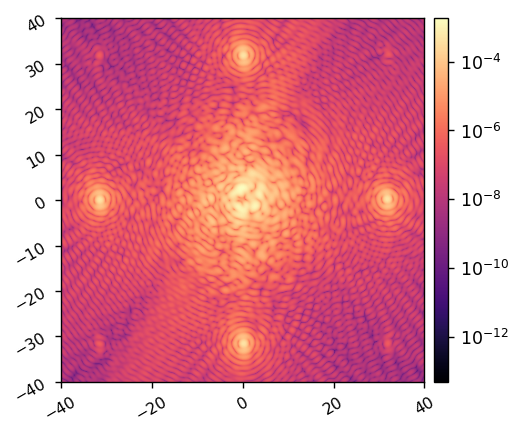

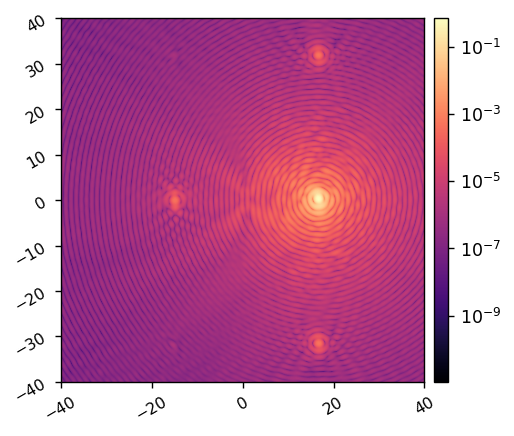

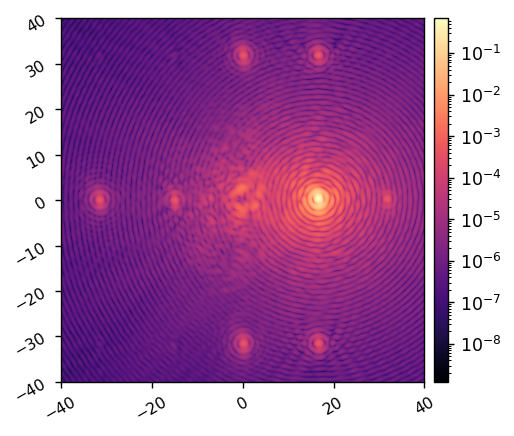

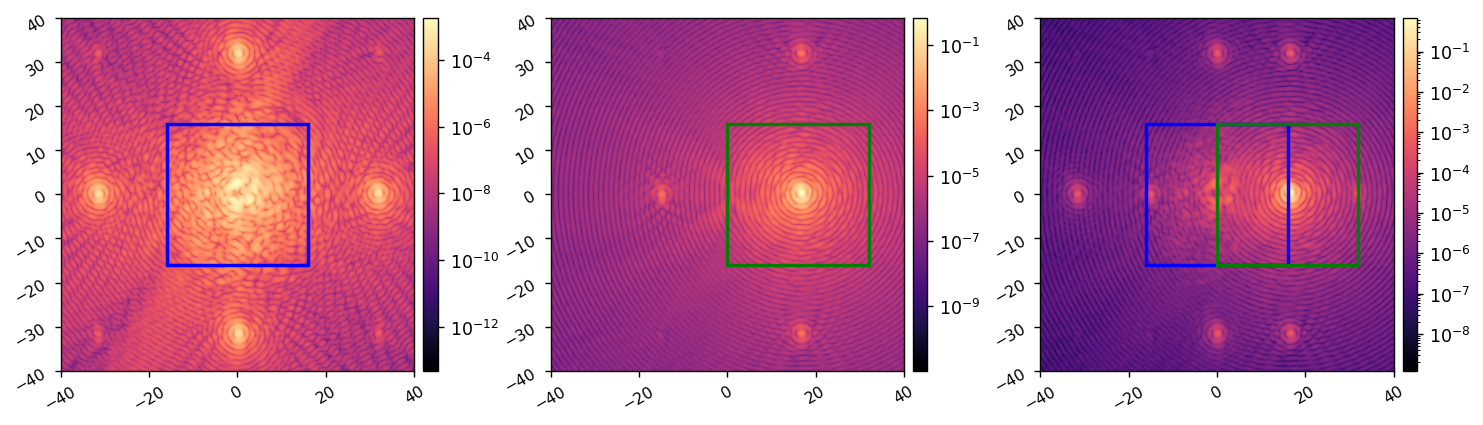

In [28]:
model.OPD = None
# model.OPD = G
model.npsf = 400
model.source_offset = (0,0)
model.reset_dm()
im_on = model.snap(True)

offset = (16,0)
model.source_offset = offset
im_off = model.snap(True)

im = im_on + im_off
imshow1(im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

rect1 = Rectangle((-16,-16), 32, 32, fill=False, linewidth=2, color='b')
rect2 = Rectangle((-16+offset[0],-16+offset[1]), 32, 32, fill=False, linewidth=2, color='g')
rect3 = Rectangle((-16,-16), 32, 32, fill=False, linewidth=2, color='b')
rect4 = Rectangle((-16+offset[0],-16+offset[1]), 32, 32, fill=False, linewidth=2, color='g')
imshow3(im_on, im_off, im, lognorm=True, pxscl=model.psf_pixelscale_lamD, 
        patches1=[rect1], patches2=[rect2], patches3=[rect3, rect4])

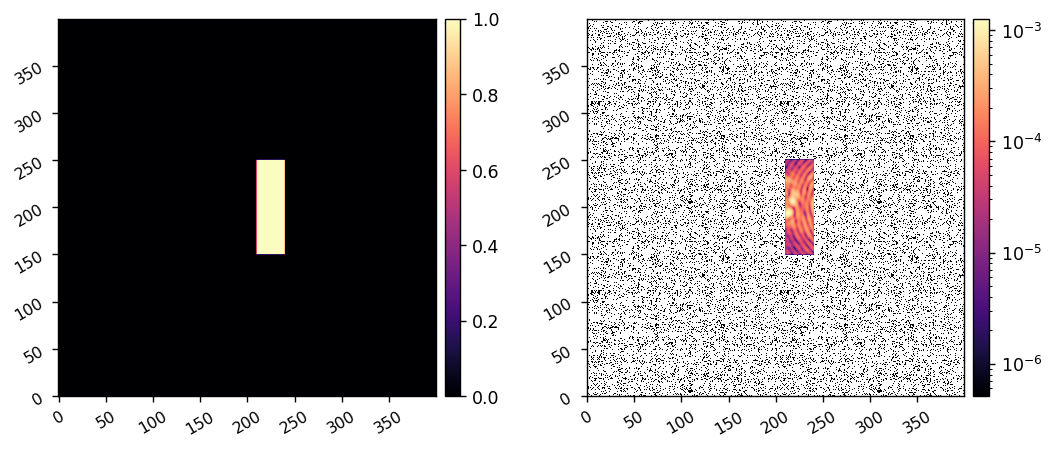

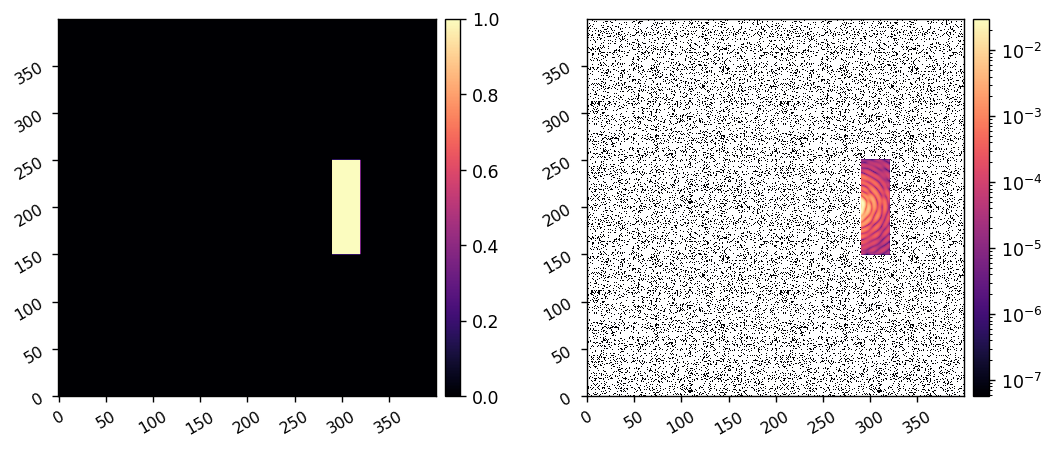

In [29]:
reload(lina.utils)
npsf = model.npsf
Nact = model.Nact

xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*model.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)

# Create the mask that is used to select which region to make dark.
dark_params = {
    'xi':2,
    'xo':8,
    'yi':-10,
    'yo':10,
}
dark_mask_on = lina.utils.create_box_focal_plane_mask(fpx, fpy, dark_params)
imshow2(dark_mask_on, dark_mask_on*im, lognorm2=True)

dark_params = {
    'xi':2,
    'xo':8,
    'yi':-10,
    'yo':10,
    'x_shift':offset[0]/model.psf_pixelscale_lamD,
    'y_shift':offset[1]/model.psf_pixelscale_lamD,
}
dark_mask_off = lina.utils.create_box_focal_plane_mask(fpx, fpy, dark_params)
imshow2(dark_mask_off, dark_mask_off*im, lognorm2=True)

control_mask = dark_mask_on

240

120

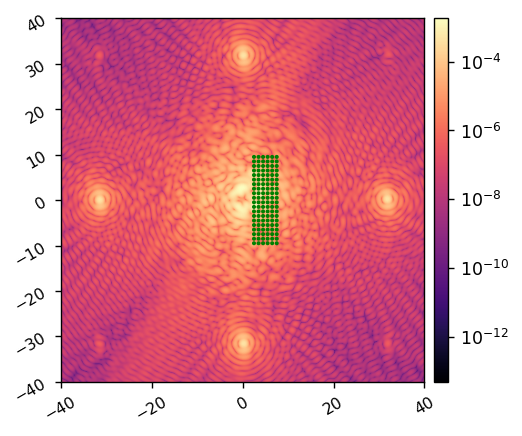

In [30]:
reload(lina.utils)

calib_amp = 5e-9
calib_modes, fs = lina.utils.select_fourier_modes(model, control_mask, fourier_sampling=1) 
nmodes = calib_modes.shape[0]
nf = nmodes//2
display(nmodes, nf)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
imshow1(occ_im, lognorm=True, pxscl=model.psf_pixelscale_lamD, patches=patches)

In [12]:
fs[0]

array([ 2.5, -9.5])

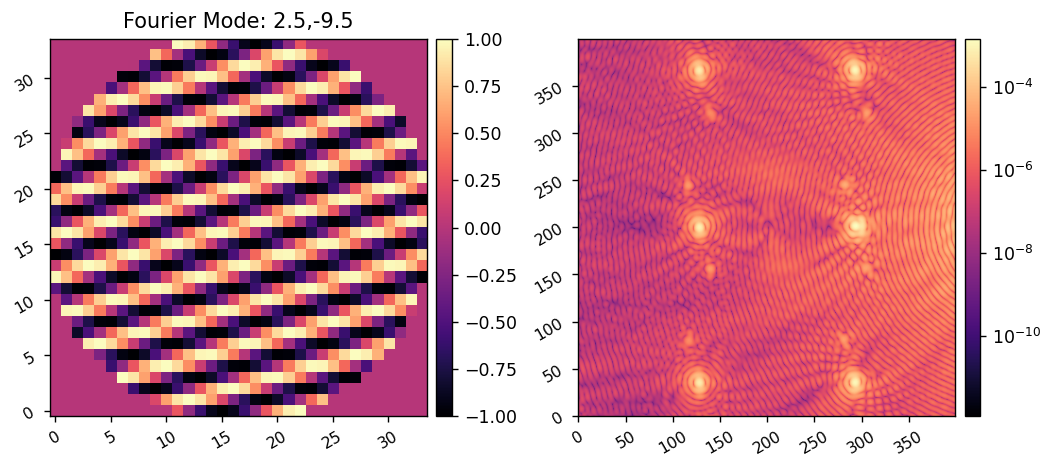

In [33]:
i = 0

model.source_offset = (50,0)
model.OPD = G
model.reset_dm()
model.add_dm(5*calib_amp*calib_modes[i].reshape(Nact,Nact))
im = model.snap()

imshow2(calib_modes[i].reshape(Nact,Nact), im, 
        'Fourier Mode: {:.1f},{:.1f}'.format(fs[i][0], fs[i][1]),
        lognorm2=True)

